In [10]:
%%capture
%pip install matplotlib numpy seaborn

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import torch
import json
import re

sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.8,
    rc={"figure.dpi": 300, "figure.constrained_layout.use": True, "lines.linewidth": 3},
)

Matplotlib is building the font cache; this may take a moment.


In [5]:
def plot_active_layers(data: dict, ax: plt.Axes):
    """
        Plot the active and inactive layers at each timestep
        x axis: time
        y axis: layer name
    """
    layer_names = data['adapter_base_names']
    activations = data['masks']
    # activations is a list of lists, where each outer index corresponds to a timestep
    # and each inner index corresponds to a layer
    # create a matrix where rows correspond to layers and columns correspond to timesteps
    activation_matrix = np.array(activations).T
    # plot the matrix
    ax.imshow(activation_matrix, cmap='viridis', aspect='auto')
    # make a heatmap on the right side of the plot
    cax = ax.inset_axes([1.05, 0, 0.05, 1])
    cbar = ax.figure.colorbar(ax.get_children()[0], cax=cax)
    cbar.set_label('Activation')
    # set the y axis labels to the layer names
    ax.set_yticks(np.arange(len(layer_names)))
    ax.set_yticklabels(layer_names)
    # set the x axis labels to the timesteps
    time_step_size = 1 if len(activations) < 10 else len(
        activations) // 10 if len(activations) < 100 else len(activations) // 100
    ax.set_xticks(np.arange(len(activations)//time_step_size))
    ax.set_xticklabels(np.arange(len(activations)//time_step_size))
    ax.xaxis.tick_top()

    return ax

In [6]:
def plot_activations(data: dict, ax: plt.Axes, key:str = None):
    """
        Plot the activations of each layer at each timestep
        x axis: time
        y axis: activation value
    """
    layer_names = data['adapter_base_names']
    cum_acts = data['cum_acts']
    # either it is a list of dicts or a list of lists
    # in the first case, we extract the 'acts' key from each dict
    if isinstance(cum_acts[0], dict) and key is None:
        raise ValueError('Key must be provided when cum_acts is a list of dicts')
    acts = [timestep[key] for timestep in cum_acts] if isinstance(cum_acts[0], dict) else cum_acts
    # outer index corresponds to a timestep
    # inner index corresponds to a layer
    # create a matrix where rows correspond to layers and columns correspond to timesteps
    activation_matrix = np.array(acts).T
    # plot the matrix
    ax.imshow(activation_matrix, cmap='viridis', aspect='auto')
    # make a heatmap on the right side of the plot
    cax = ax.inset_axes([1.05, 0, 0.05, 1])
    cbar = ax.figure.colorbar(ax.get_children()[0], cax=cax)
    cbar.set_label('Activation')
    # set the y axis labels to the layer names
    ax.set_yticks(np.arange(len(layer_names)))
    ax.set_yticklabels(layer_names)
    # set the x axis labels to the timesteps
    # located at the top of the plot
    time_step_size = 1 if len(acts) < 10 else len(acts) // 10 if len(acts) < 100 else len(acts) // 100
    ax.set_xticks(np.arange(len(acts)//time_step_size))
    ax.set_xticklabels(np.arange(len(acts)//time_step_size))
    # located at the top of the plot
    ax.xaxis.tick_top()

    return ax

In [7]:
def plot_heatmap(data: dict, prefix: str, ax: plt.Axes):
    """
        Plot the heatmap of the activations in a grid
    """
    layer_names = data['adapter_base_names']
    activations = np.array(data['masks'])
    # sum by the columns
    activations = np.sum(activations, axis=0)
    assert activations.shape == (len(layer_names),)
    # layer names have a single index element
    # e.g. robetra_base.encoder.layer.<index>.attention...
    # which we divide into <prefix>, <index>, <suffix>
    # group the layers by their index first and their suffix second
    layer_groups = {}
    for layer_name, sum_act in zip(layer_names, activations):
        if not layer_name.startswith(prefix):
            print(f'Skipping layer {layer_name}')
            continue # skip
        layer_name = layer_name[len(prefix):]
        index, suffix = re.match(r'(\D*\d+)(.*)', layer_name).groups()
        if index not in layer_groups:
            layer_groups[index] = {}
        layer_groups[index][suffix] = sum_act
    # create a matrix where rows correspond to the layer index
    # and columns correspond to the suffix
    act_matrix = np.zeros((len(layer_groups), len(list(layer_groups.values())[0])))
    for i, elem in enumerate(layer_groups.items()):
        lg, layer_group = elem
        for j, suffix in enumerate(layer_group.items()):
            act_matrix[i, j] = suffix[1]
    # plot the matrix
    ax.imshow(act_matrix, cmap='viridis', aspect='auto', vmin=0)
    # make a heatmap on the right side of the plot
    cax = ax.inset_axes([1.05, 0, 0.05, 1])
    cbar = ax.figure.colorbar(ax.get_children()[0], cax=cax)
    cbar.set_label('Number of active steps')
    # set the y axis labels to the layer index
    ax.set_yticks(np.arange(len(layer_groups)))
    ax.set_yticklabels(layer_groups.keys())
    # set the y axis caption to the prefix
    ax.set_ylabel(prefix)
    # set the x axis labels to the suffix
    ax.set_xticks(np.arange(act_matrix.shape[1]))
    ax.set_xticklabels(layer_groups['0'].keys())
    ax.xaxis.tick_top()

    return ax

In [89]:
# path to the JSON file
data_path = '../output/dynalora_logs.json'
with open(data_path, 'r') as f:
    data = json.load(f)
schedule = data['schedule']
allocator = data['allocator']
aggregate = data['aggregate']
print('Schedule:', schedule)
print('Allocator:', allocator)
print('Aggregator:', aggregate)

Schedule: periodic;10
Allocator: scaled_multinomial;10;0.01
Aggregator: l2


Skipping layer classifier.dense
Skipping layer classifier.out_proj


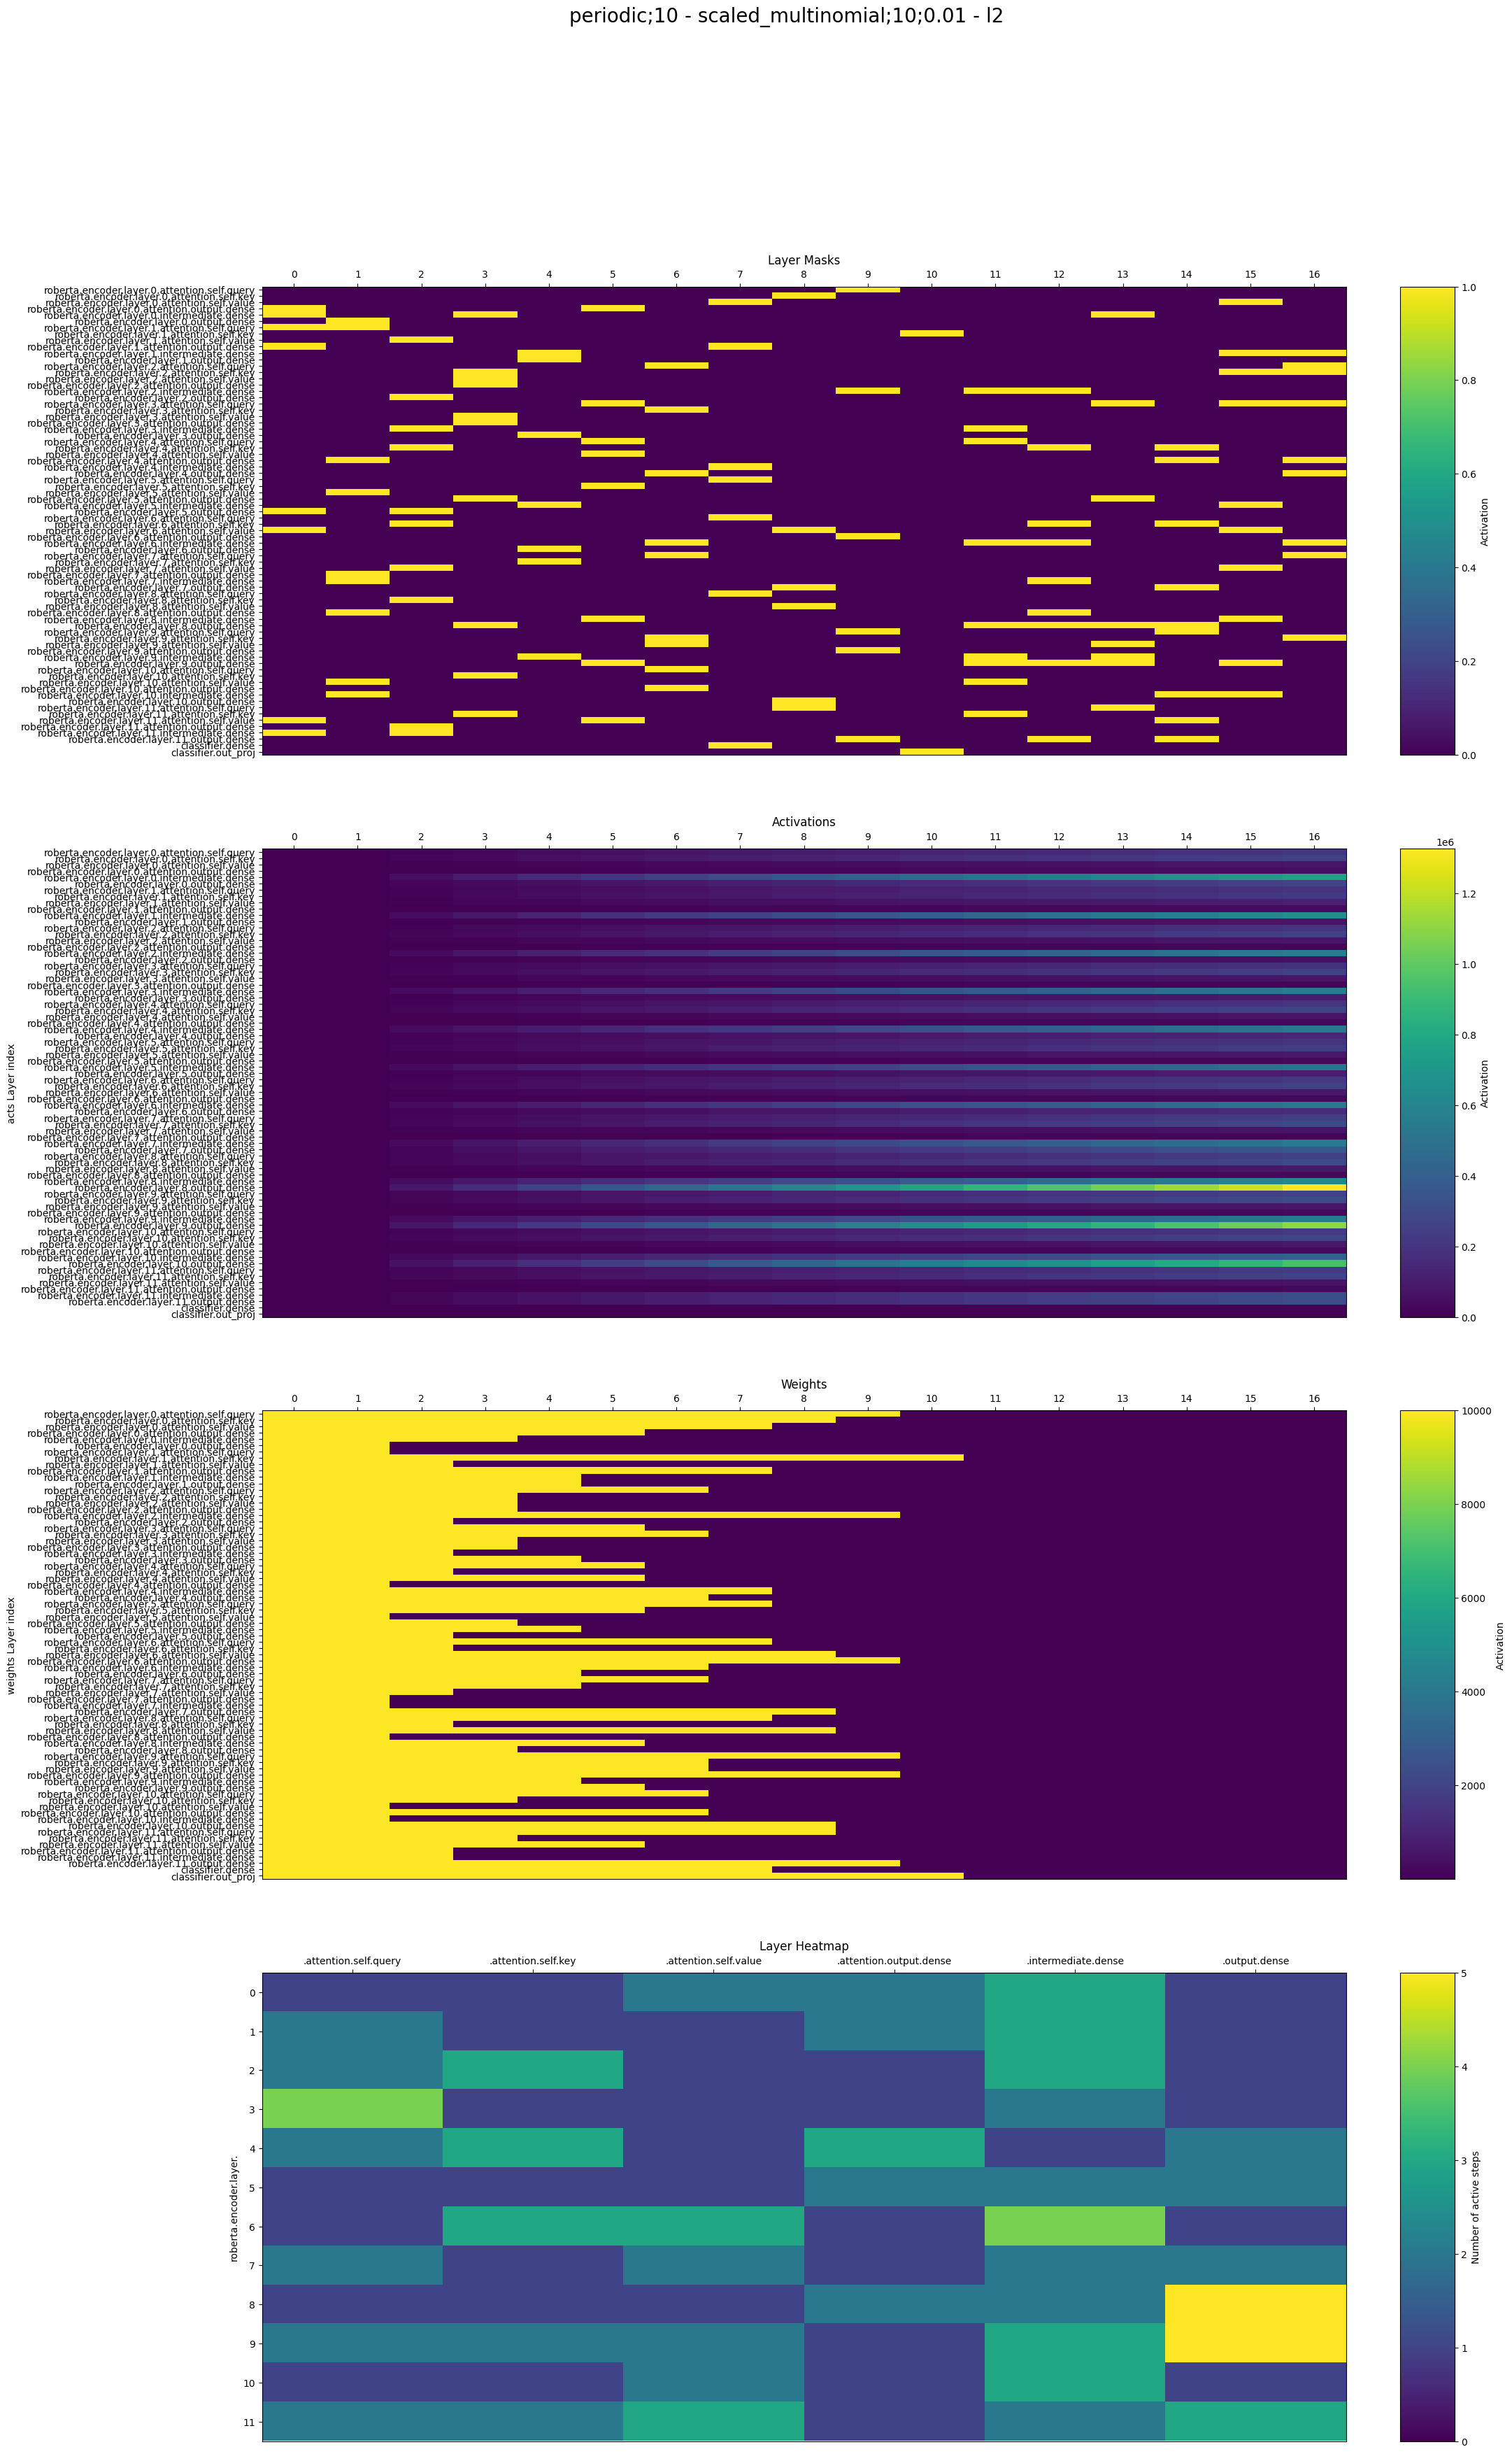

In [97]:
fig, axs = plt.subplots(4, 1, figsize=(20, 40))

fig.suptitle('{} - {} - {}'.format(schedule, allocator, aggregate), fontsize=20)
axs[0] = plot_active_layers(data, axs[0])
axs[0].set_title('Layer Masks')
axs[1] = plot_activations(data, axs[1], key='acts')
axs[1].set_title('Activations')
axs[2] = plot_activations(data, axs[2], key='weights')
axs[2].set_title('Weights')
axs[3] = plot_heatmap(data, prefix='roberta.encoder.layer.', ax=axs[3])
axs[3].set_title('Layer Heatmap')

plt.show()